In [1]:
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import scipy.io, cv2

# Find images path
scene_paths = glob('../Dataset_CNN/*/')

# Fulfill data
X_ = []
y_ = []
Xtest_ = []
ytest_ = []

print('Loading training data')
for scene in scene_paths[0:-6]:
    print(scene)
    windows_path = glob(scene + '*')
    
    for window in windows_path:
        images_ref_path = glob(window + '/w_*.jpg')
        NLF_path = window + '/NLF_filtered.mat'
        
        mat = scipy.io.loadmat(NLF_path)
        NLF = (mat["NLF_step_filt"][0])
        NLF[np.isnan(NLF)] = 0
        
        for img_ref in images_ref_path[0:5]:
            img = plt.imread(img_ref)
            
            X_.append(img)
            y_.append(NLF*100)

print('Loading testing data')
for scene in scene_paths[-6::]:
    print(scene)
    windows_path = glob(scene + '*')
    
    for window in windows_path:
        images_ref_path = glob(window + '/w_*.jpg')
        NLF_path = window + '/NLF_filtered.mat'
        
        mat = scipy.io.loadmat(NLF_path)
        NLF = (mat["NLF_step_filt"][0])
        NLF[np.isnan(NLF)] = 0
            
        for img_ref in images_ref_path[0:5]:
            img = plt.imread(img_ref)
            
            Xtest_.append(img)
            ytest_.append(NLF*100)
            

Loading training data
../Dataset_CNN/Scene_30/
../Dataset_CNN/Scene_35/
../Dataset_CNN/Scene_36/
../Dataset_CNN/Scene_21/
../Dataset_CNN/Scene_33/
../Dataset_CNN/Scene_07/
../Dataset_CNN/Scene_32/
../Dataset_CNN/Scene_34/
../Dataset_CNN/Scene_11/
../Dataset_CNN/Scene_10/
../Dataset_CNN/Scene_13/
../Dataset_CNN/Scene_31/
../Dataset_CNN/Scene_08/
../Dataset_CNN/Scene_23/
../Dataset_CNN/Scene_15/
../Dataset_CNN/Scene_24/
../Dataset_CNN/Scene_19/
../Dataset_CNN/Scene_22/
../Dataset_CNN/Scene_20/
../Dataset_CNN/Scene_12/
../Dataset_CNN/Scene_09/
../Dataset_CNN/Scene_26/
../Dataset_CNN/Scene_06/
../Dataset_CNN/Scene_28/
../Dataset_CNN/Scene_18/
../Dataset_CNN/Scene_29/
Loading testing data
../Dataset_CNN/Scene_17/
../Dataset_CNN/Scene_27/
../Dataset_CNN/Scene_16/
../Dataset_CNN/Scene_14/
../Dataset_CNN/Scene_25/
../Dataset_CNN/Scene_05/


In [2]:
X_ = np.asarray(X_)
y_ = np.asarray(y_)

Xtest_ = np.asarray(Xtest_)
ytest_ = np.asarray(ytest_)


In [3]:
print(np.shape(X_))
print(np.shape(y_))
print()
print(np.shape(Xtest_))
print(np.shape(ytest_))

(28080, 256, 256, 3)
(28080, 192)

(6480, 256, 256, 3)
(6480, 192)


### Crear modelo

In [4]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Reshape
from keras.layers import concatenate, AveragePooling2D, Activation, BatchNormalization
from keras.models import Model
from SpatialPyramidPooling import SpatialPyramidPooling
from keras.layers import LeakyReLU
import keras
# First, define the vision modules
input_imgs = Input(shape=(256, 256, 3))

# Model
def get_model_column(ks_1, ks_2, p_):
    x = Conv2D(64, kernel_size=(ks_1,ks_1), strides = 2, activation=None)(input_imgs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D((2, 2))(x)
    x = Conv2D(64, kernel_size=(ks_2,ks_2), activation=None)(x) # conv2_a
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D((2, 2))(x) # pool2_a
    x = Conv2D(64, kernel_size=(ks_2,ks_2), activation=None)(x) # conv2_a
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, kernel_size=(ks_2,ks_2), activation=None)(x) # conv2_a
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #out = x #keras.layers.ZeroPadding2D(padding=((p_, 0), (0, p_)), data_format=None)(x)
    x = Flatten()(x)
    x = Dense(2048, activation='relu',
                  bias_initializer='ones', kernel_initializer = 'glorot_normal')(x)
    out = Dense(64*3, activation='relu',
                  bias_initializer='ones', kernel_initializer = 'glorot_normal')(x)
    return out

# Create independent models
model_a = Model(input_imgs, get_model_column(5, 3, 0))
model_b = Model(input_imgs, get_model_column(7, 5, 5))
model_c = Model(input_imgs, get_model_column(9, 7, 10))


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


### Training

In [5]:
from keras import optimizers
from keras import losses

sgd = optimizers.SGD(lr=0.001, decay=0.0001, momentum=0.9, nesterov=True)

# compile model (abc)
#model_abc.compile(optimizer= sgd, loss='mse')
#model_abc.compile(optimizer= sgd, loss=losses.kullback_leibler_divergence)


In [6]:
import matplotlib.pyplot as plt

def pred_mc_indep_net(model, ii, abc):
    
    if abc: 
        y_pred = np.transpose(model.predict([[X_[ii]], [X_[ii]], [X_[ii]]]))
    else:
        y_pred = np.transpose(model.predict([[X_[ii]]]))

    fig, ax = plt.subplots()
    #y_pred[y_pred < 0] = 0
    ax.plot(y_pred,'r')

    ax.set(xlabel='intensity', ylabel='std',
           title='pred nlf')
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(y_[ii],'r')

    ax.set(xlabel='intensity', ylabel='std',
           title='test nlf')
    plt.show()
    
def train_indep_model(model, X_, y_, Xtest_, ytest_, std_, abc = False):
    # Variables for convergence checking
    converged = False

    print()
    std_thold = std_
    
    count = 0
    hist_loss = []
    hist_val_loss = []

    while not converged:

        print('Iteration ' + str(count+1))

        # Training the model
        history = model.fit(x=X_, y=y_, validation_data=(Xtest_, ytest_), 
                                epochs=1, shuffle=True, batch_size = 64)

        pred_mc_indep_net(model, 0, abc)

        count += 1
        mean_samples = 6

        # Checking the convergence of the model using the standard deviation of the accuracy for some epochs
        hist_loss.extend(history.history["loss"])
        hist_val_loss.extend(history.history["val_loss"])    

        used_hist_val_loss = hist_val_loss[max(0,len(hist_val_loss)-mean_samples):len(hist_val_loss)]

        if len(used_hist_val_loss) >= mean_samples:
            mean_acc = float(sum(np.asarray(used_hist_val_loss)))/float(len(used_hist_val_loss))
            std_cutre = float(sum(np.abs(np.asarray(used_hist_val_loss)-mean_acc)))/float(len(used_hist_val_loss))

            print("STD OF " + str(len(used_hist_val_loss)) + ' SAMPLES: '),
            print(std_cutre)

            if std_cutre < std_thold or count > 50:
                converged = True
                return model, hist_loss, hist_val_loss


        else:
            # converged = True # Useful for testing
            print("Not enough samples to compute the STD :(")

        print('\n')
        
        

In [7]:
model_a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 64)      4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 64)      0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
__________

In [8]:
'''std_ = 0.1

# Train model A
print('Model A')
model_a.compile(optimizer= sgd, loss='mse')
model_a, hist_loss_a, hist_val_loss_a = train_indep_model(model_a, X_, y_, Xtest_, ytest_, std_)
# Train model B
print('Model B')
model_b.compile(optimizer= sgd, loss='mse')
model_b, hist_loss_b, hist_val_loss_b = train_indep_model(model_b, X_, y_, Xtest_, ytest_, std_)
# Train model C
print('Model C')
model_c.compile(optimizer= sgd, loss='mse')
model_c, hist_loss_c, hist_val_loss_c = train_indep_model(model_c, X_, y_, Xtest_, ytest_, std_)'''

"std_ = 0.1\n\n#\xa0Train model A\nprint('Model A')\nmodel_a.compile(optimizer= sgd, loss='mse')\nmodel_a, hist_loss_a, hist_val_loss_a = train_indep_model(model_a, X_, y_, Xtest_, ytest_, std_)\n# Train model B\nprint('Model B')\nmodel_b.compile(optimizer= sgd, loss='mse')\nmodel_b, hist_loss_b, hist_val_loss_b = train_indep_model(model_b, X_, y_, Xtest_, ytest_, std_)\n# Train model C\nprint('Model C')\nmodel_c.compile(optimizer= sgd, loss='mse')\nmodel_c, hist_loss_c, hist_val_loss_c = train_indep_model(model_c, X_, y_, Xtest_, ytest_, std_)"

In [9]:
'''prefix = '2505'
# serialize model to JSON
model_json = model_a.to_json()
with open(f"models/model_a_{prefix}.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_a.save_weights(f"models/model_a_{prefix}.h5")
print("Saved model to disk")

# serialize model to JSON
model_json = model_b.to_json()
with open(f"models/model_b_{prefix}.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_b.save_weights(f"models/model_b_{prefix}.h5")
print("Saved model to disk")

# serialize model to JSON
model_json = model_c.to_json()
with open(f"models/model_c_{prefix}.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_c.save_weights(f"models/model_c_{prefix}.h5")
print("Saved model to disk")

# save histories
import pickle
pickle.dump( hist_loss_a, open( "models/hist_loss_a.pickle", "wb" ) )
pickle.dump( hist_val_loss_a, open( "models/hist_val_loss_a.pickle", "wb" ) )

pickle.dump( hist_loss_b, open( "models/hist_loss_b.pickle", "wb" ) )
pickle.dump( hist_val_loss_b, open( "models/hist_val_loss_b.pickle", "wb" ) )

pickle.dump( hist_loss_c, open( "models/hist_loss_c.pickle", "wb" ) )
pickle.dump( hist_val_loss_c, open( "models/hist_val_loss_c.pickle", "wb" ) )'''

'prefix = \'2505\'\n# serialize model to JSON\nmodel_json = model_a.to_json()\nwith open(f"models/model_a_{prefix}.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\nmodel_a.save_weights(f"models/model_a_{prefix}.h5")\nprint("Saved model to disk")\n\n# serialize model to JSON\nmodel_json = model_b.to_json()\nwith open(f"models/model_b_{prefix}.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\nmodel_b.save_weights(f"models/model_b_{prefix}.h5")\nprint("Saved model to disk")\n\n# serialize model to JSON\nmodel_json = model_c.to_json()\nwith open(f"models/model_c_{prefix}.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\nmodel_c.save_weights(f"models/model_c_{prefix}.h5")\nprint("Saved model to disk")\n\n# save histories\nimport pickle\npickle.dump( hist_loss_a, open( "models/hist_loss_a.pickle", "wb" ) )\npickle.dump( hist_val_loss_a, open( "models/hist_val_loss_a.pickle", 

In [10]:
from keras.models import model_from_json
# load model
'''json_file = open("models/model_a_0405.json", "r")
loaded_model_json = json_file.read()
json_file.close()
model_a = model_from_json(loaded_model_json)'''

prefix = '2505'
model_a.load_weights(f"models/model_a_{prefix}.h5")
print('loaded model')

loaded model


In [11]:
from keras.models import model_from_json
'''# load model
json_file = open("models/model_b_0405.json", "r")
loaded_model_json = json_file.read()
json_file.close()
model_b = model_from_json(loaded_model_json)'''

model_b.load_weights(f"models/model_b_{prefix}.h5")
print('loaded model')

loaded model


In [12]:
from keras.models import model_from_json
# load model
'''json_file = open("models/model_c_0405.json", "r")
loaded_model_json = json_file.read()
json_file.close()
model_c = model_from_json(loaded_model_json)
'''
model_c.load_weights(f"models/model_c_{prefix}.h5")
print('loaded model')

loaded model


In [13]:
model_a.layers.pop()
model_a.layers.pop()
model_a.layers.pop()
model_b.layers.pop()
model_b.layers.pop()
model_b.layers.pop()
model_c.layers.pop()
model_c.layers.pop()
model_c.layers.pop()

In [14]:
out_a = model_a.layers[-1].output
model_a = keras.layers.ZeroPadding2D(padding=((0, 0), (0, 0)), data_format=None)(out_a)
out_b = model_b.layers[-1].output
model_b = keras.layers.ZeroPadding2D(padding=((5, 0), (0, 5)), data_format=None)(out_b)
out_c = model_c.layers[-1].output
model_c = keras.layers.ZeroPadding2D(padding=((10, 0), (0, 10)), data_format=None)(out_c)

In [15]:
modelA = Model(input=input_imgs,output=model_a)
modelB = Model(input=input_imgs,output=model_b)
modelC = Model(input=input_imgs,output=model_c)

/home/plyzer-ai/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ze...)`
  """Entry point for launching an IPython kernel.
/home/plyzer-ai/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ze...)`
  
/home/plyzer-ai/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ze...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
modelA.summary()
modelB.summary()
modelC.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 64)      4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 64)      0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
__________

In [17]:
from keras.layers import Input, concatenate, Dense
from keras.models import Model
from SpatialPyramidPooling import SpatialPyramidPooling

# Then define the input-apart model
input_a = Input(shape=(256, 256, 3))
input_b = Input(shape=(256, 256, 3)) 
input_c = Input(shape=(256, 256, 3)) 

# The vision model will be shared, weights and all
out_a = modelA(input_a)
out_b = modelB(input_b)
out_c = modelC(input_c)

concatenated = concatenate([out_a, out_b, out_c],axis=3)
merge_abc = SpatialPyramidPooling([1, 2, 4])(concatenated)
merge_abc = Dense(2048, activation='relu',
                  bias_initializer='ones', kernel_initializer = 'glorot_normal')(merge_abc)
merge_abc = Dense(64*3, activation='relu',
                  bias_initializer='ones', kernel_initializer = 'glorot_normal')(merge_abc)
model_abc = Model([input_a, input_b, input_c], merge_abc)

'''model_abc.load_weights("models/model_abc_0405_2.h5")
print('loaded model')'''

'model_abc.load_weights("models/model_abc_0405_2.h5")\nprint(\'loaded model\')'

In [18]:
model_abc.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 26, 26, 64)   116672      input_2[0][0]                    
__________________________________________________________________________________________________
model_5 (M


Iteration 1
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 85s 3ms/step - loss: 3.0262 - val_loss: 0.8112


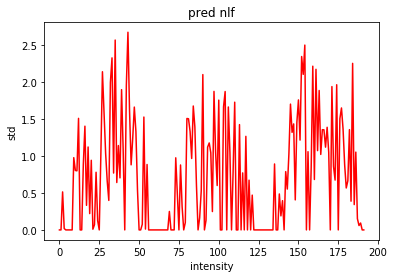

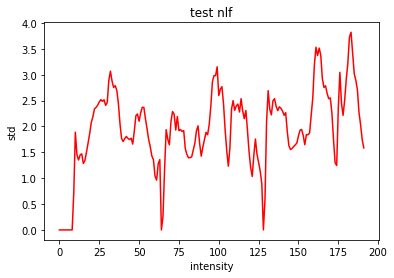

Not enough samples to compute the STD :(


Iteration 2
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 82s 3ms/step - loss: 2.6741 - val_loss: 0.7715


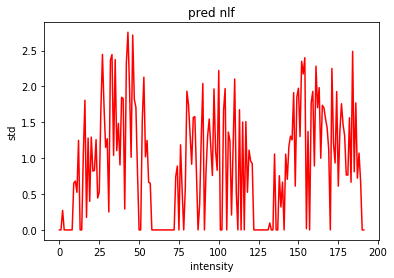

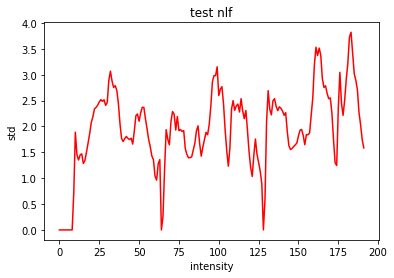

Not enough samples to compute the STD :(


Iteration 3
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 82s 3ms/step - loss: 2.4978 - val_loss: 0.7653


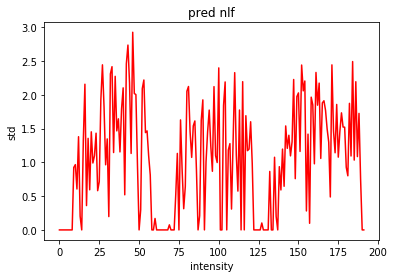

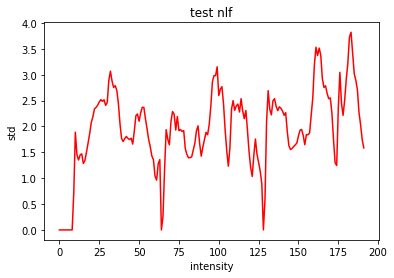

Not enough samples to compute the STD :(


Iteration 4
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 82s 3ms/step - loss: 2.3608 - val_loss: 0.7515


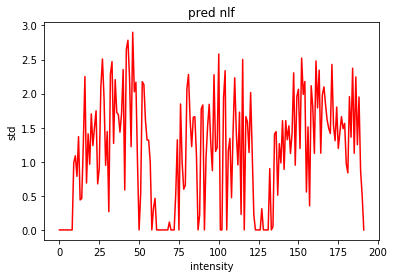

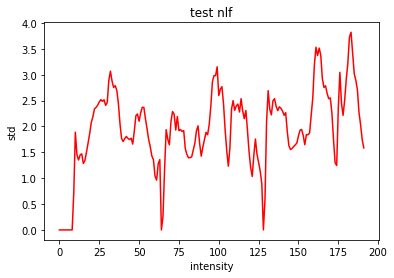

Not enough samples to compute the STD :(


Iteration 5
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 81s 3ms/step - loss: 2.2032 - val_loss: 0.8057


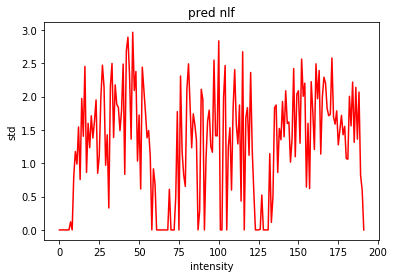

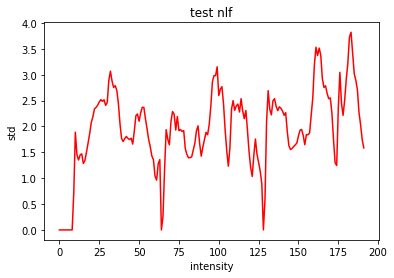

Not enough samples to compute the STD :(


Iteration 6
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 82s 3ms/step - loss: 2.0833 - val_loss: 0.8224


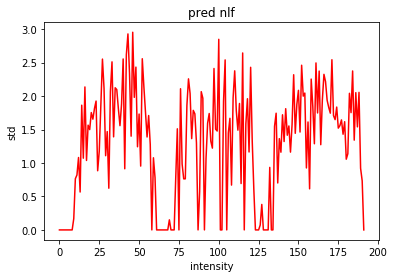

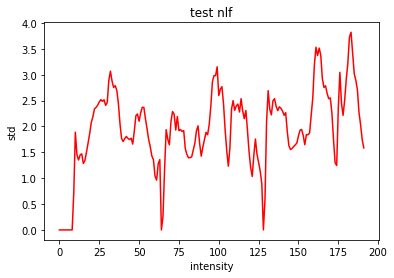

STD OF 6 SAMPLES: 
0.025157440346454896


Iteration 7
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 83s 3ms/step - loss: 1.9694 - val_loss: 0.8345


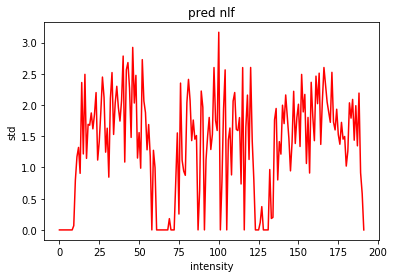

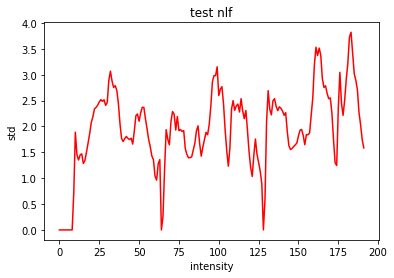

STD OF 6 SAMPLES: 
0.029043186544881434


Iteration 8
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 83s 3ms/step - loss: 1.8676 - val_loss: 0.7923


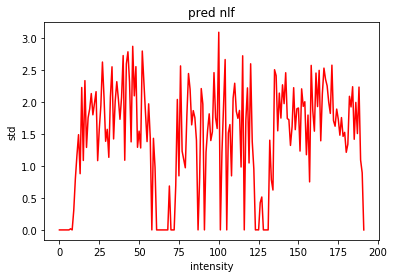

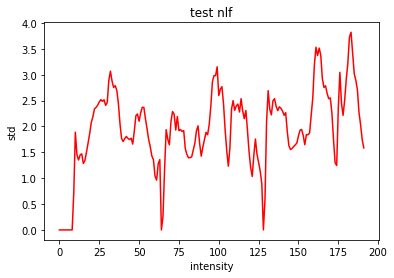

STD OF 6 SAMPLES: 
0.025578687907246395


Iteration 9
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 83s 3ms/step - loss: 1.8023 - val_loss: 0.7969


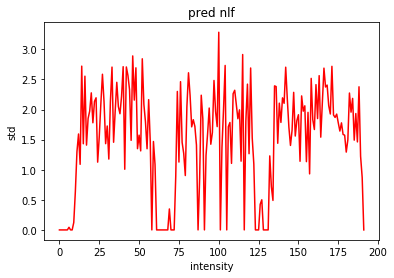

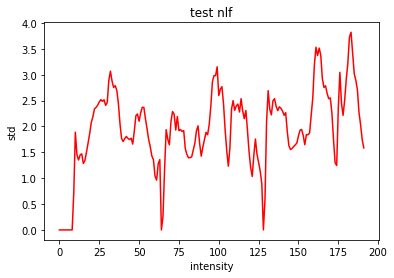

STD OF 6 SAMPLES: 
0.020306751831078235


Iteration 10
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 83s 3ms/step - loss: 1.7173 - val_loss: 0.7454


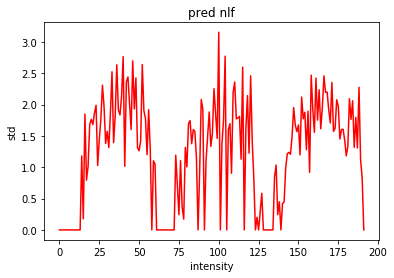

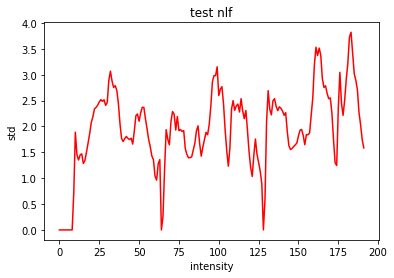

STD OF 6 SAMPLES: 
0.021321098426732504


Iteration 11
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 83s 3ms/step - loss: 1.6762 - val_loss: 0.9265


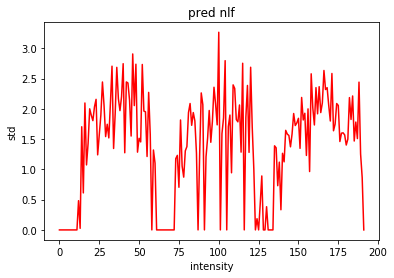

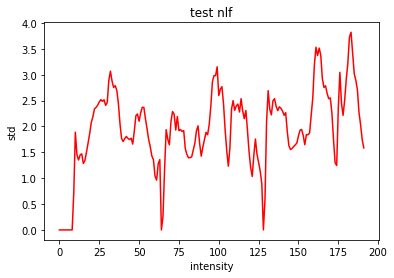

STD OF 6 SAMPLES: 
0.04145227832558712


Iteration 12
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 83s 3ms/step - loss: 1.5934 - val_loss: 1.1134


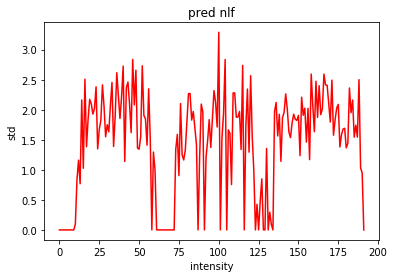

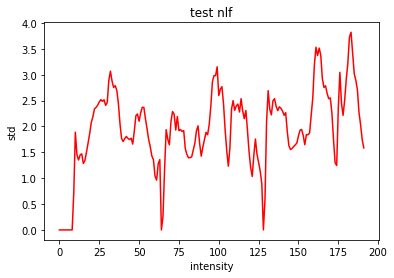

STD OF 6 SAMPLES: 
0.10118754562527062


Iteration 13
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 83s 3ms/step - loss: 1.5651 - val_loss: 0.7291


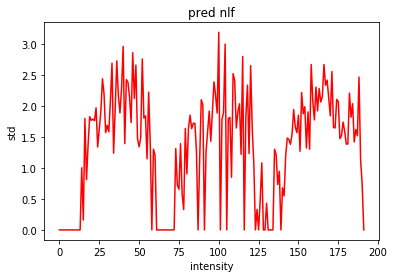

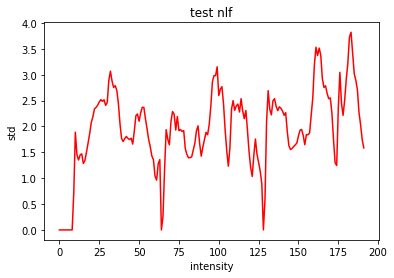

STD OF 6 SAMPLES: 
0.11290071646699527


Iteration 14
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 83s 3ms/step - loss: 1.5332 - val_loss: 0.8009


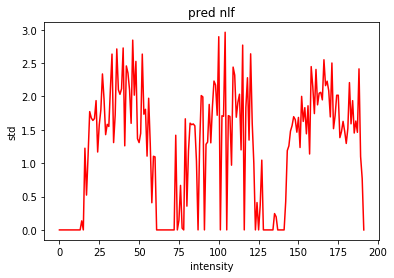

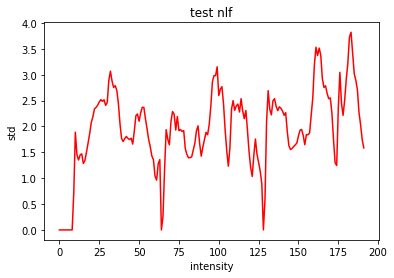

STD OF 6 SAMPLES: 
0.11194611859746756


Iteration 15
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 83s 3ms/step - loss: 1.4980 - val_loss: 0.7053


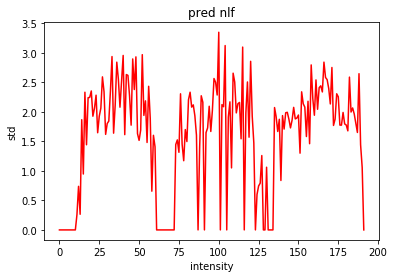

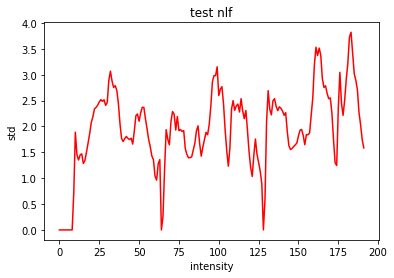

STD OF 6 SAMPLES: 
0.12212126691645551


Iteration 16
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 83s 3ms/step - loss: 1.4680 - val_loss: 0.8787


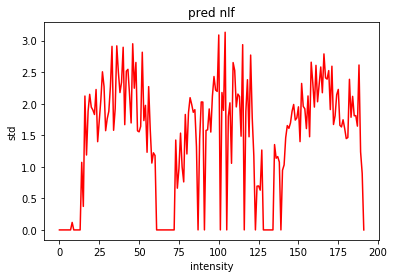

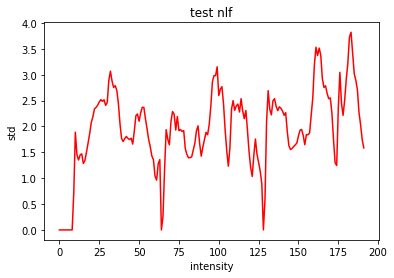

STD OF 6 SAMPLES: 
0.11388216222264637


Iteration 17
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 83s 3ms/step - loss: 1.4073 - val_loss: 1.0891


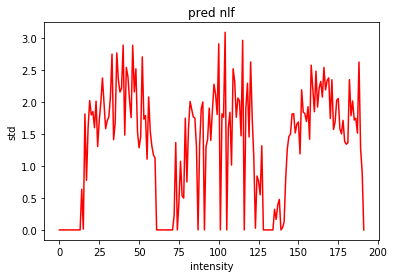

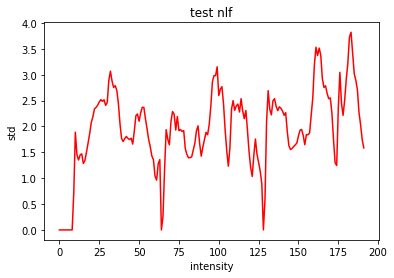

STD OF 6 SAMPLES: 
0.1434523333410831


Iteration 18
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 83s 3ms/step - loss: 1.3809 - val_loss: 0.8830


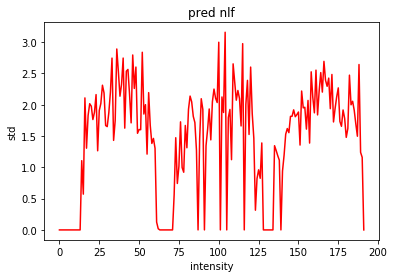

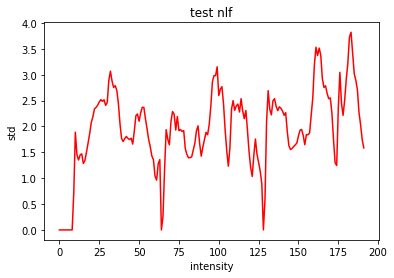

STD OF 6 SAMPLES: 
0.10258792525946851


Iteration 19
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 83s 3ms/step - loss: 1.3395 - val_loss: 0.7815


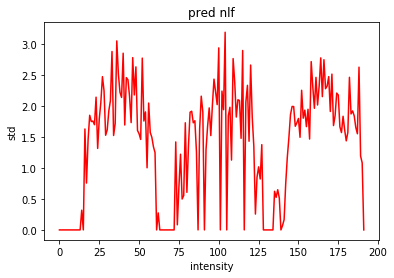

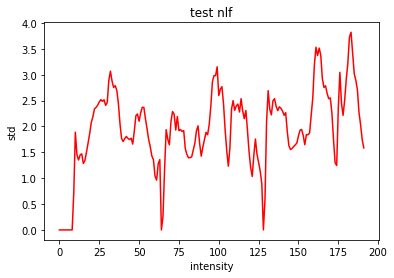

STD OF 6 SAMPLES: 
0.0938447256637699


Iteration 20
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 83s 3ms/step - loss: 1.3213 - val_loss: 0.6840


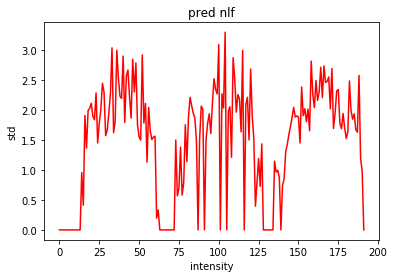

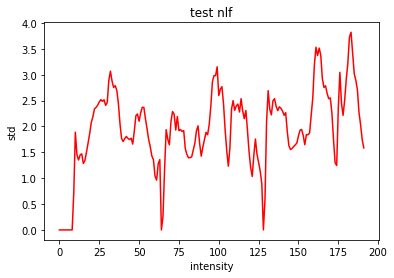

STD OF 6 SAMPLES: 
0.11332032356733161


Iteration 21
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 84s 3ms/step - loss: 1.3029 - val_loss: 0.7537


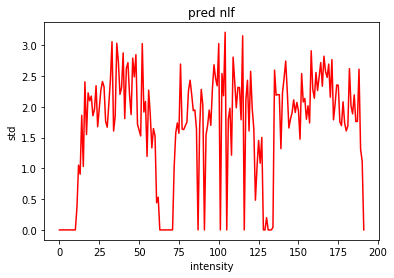

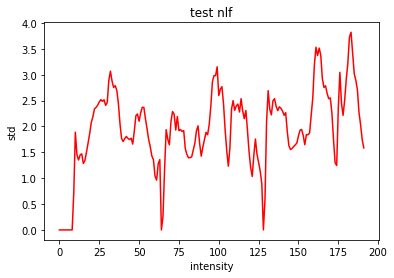

STD OF 6 SAMPLES: 
0.10525925836445377


Iteration 22
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 83s 3ms/step - loss: 1.2891 - val_loss: 0.6645


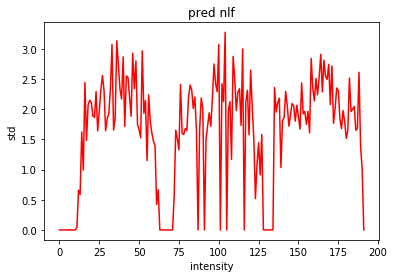

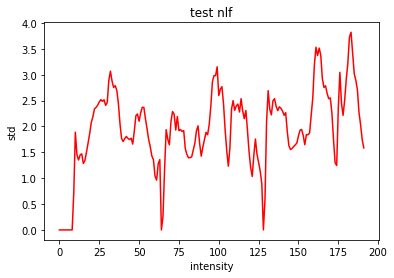

STD OF 6 SAMPLES: 
0.11783128507506872


Iteration 23
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 83s 3ms/step - loss: 1.2875 - val_loss: 1.0216


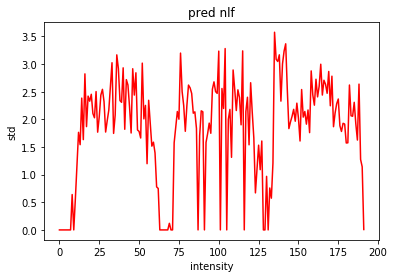

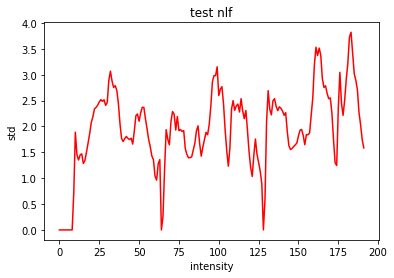

STD OF 6 SAMPLES: 
0.10281814377657834


Iteration 24
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 83s 3ms/step - loss: 1.2614 - val_loss: 0.6597


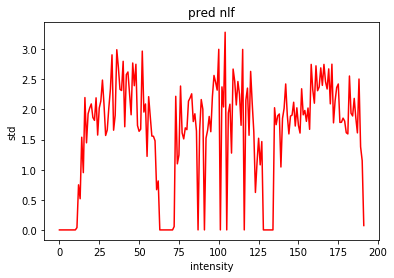

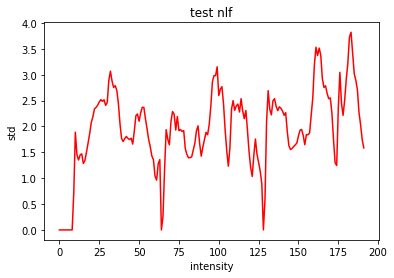

STD OF 6 SAMPLES: 
0.09380051111815235


Iteration 25
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 83s 3ms/step - loss: 1.2542 - val_loss: 0.7112


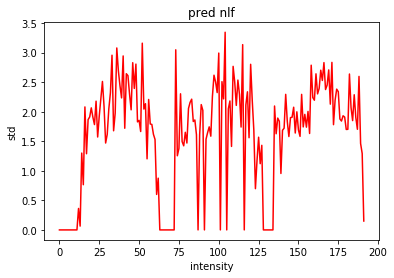

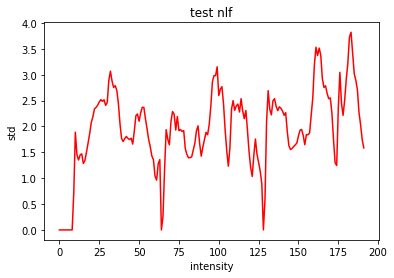

STD OF 6 SAMPLES: 
0.09233286992349089


Iteration 26
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 83s 3ms/step - loss: 1.2251 - val_loss: 0.9386


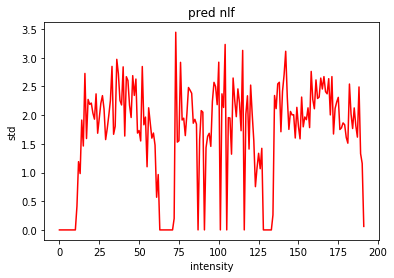

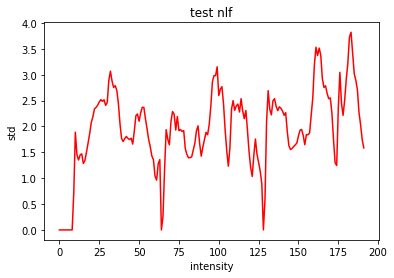

STD OF 6 SAMPLES: 
0.125692104590119


Iteration 27
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 83s 3ms/step - loss: 1.2120 - val_loss: 1.0703


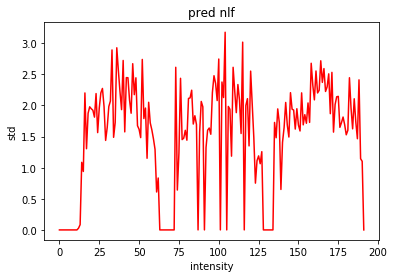

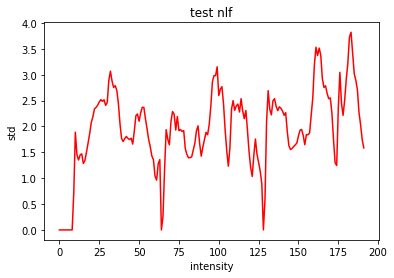

STD OF 6 SAMPLES: 
0.16583708485458123


Iteration 28
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 82s 3ms/step - loss: 1.2041 - val_loss: 0.6774


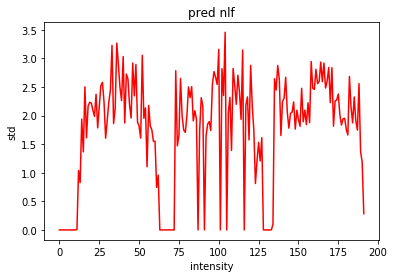

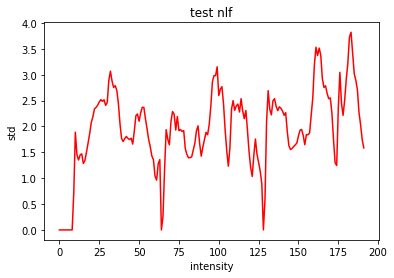

STD OF 6 SAMPLES: 
0.16369630267590654


Iteration 29
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 82s 3ms/step - loss: 1.1948 - val_loss: 0.7568


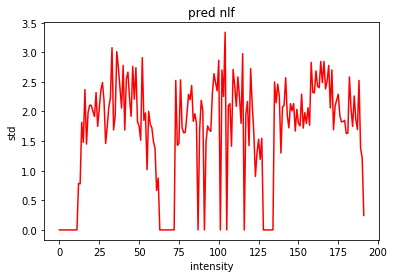

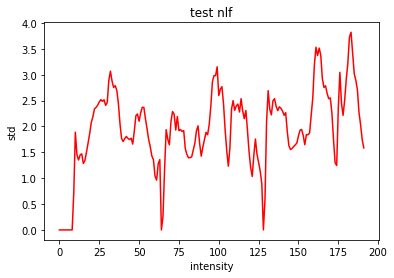

STD OF 6 SAMPLES: 
0.1347532961757749


Iteration 30
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 83s 3ms/step - loss: 1.1790 - val_loss: 0.6485


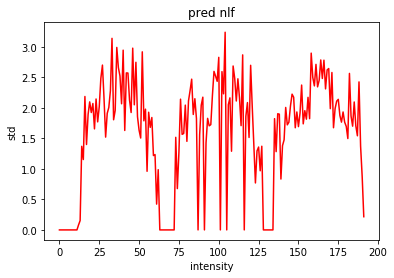

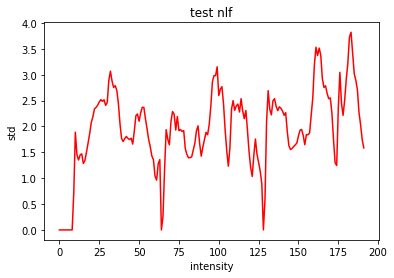

STD OF 6 SAMPLES: 
0.13600301662426756


Iteration 31
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 81s 3ms/step - loss: 1.1762 - val_loss: 0.7077


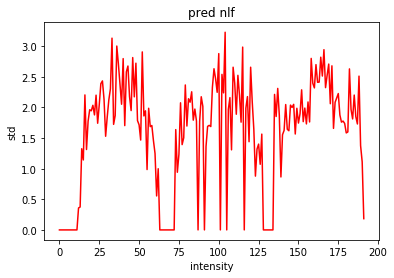

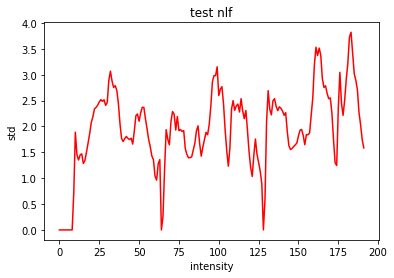

STD OF 6 SAMPLES: 
0.1363983258298395


Iteration 32
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 82s 3ms/step - loss: 1.1613 - val_loss: 0.5949


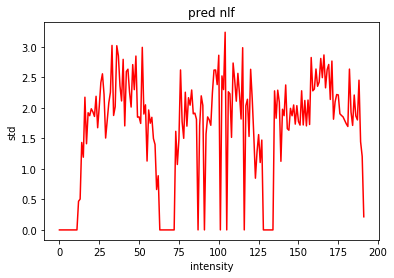

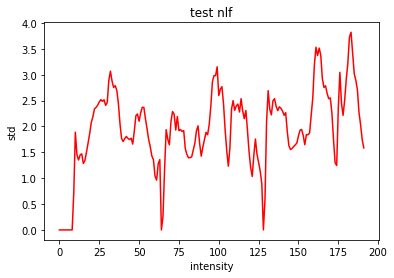

STD OF 6 SAMPLES: 
0.11396218098403661


Iteration 33
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 84s 3ms/step - loss: 1.1431 - val_loss: 0.7461


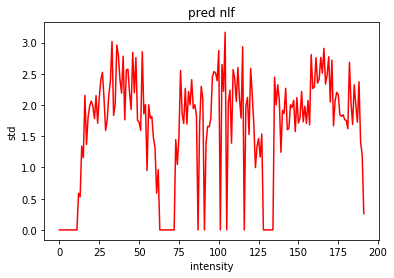

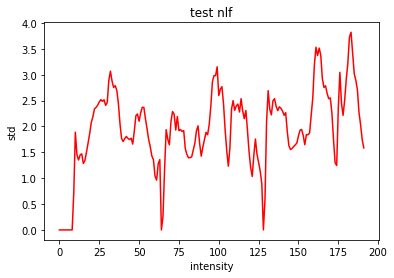

STD OF 6 SAMPLES: 
0.04828989260481218


Iteration 34
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 85s 3ms/step - loss: 1.1458 - val_loss: 0.8412


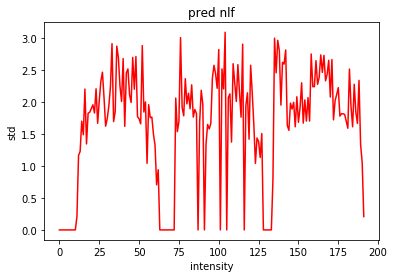

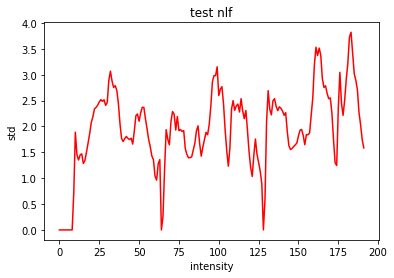

STD OF 6 SAMPLES: 
0.06549469212936275


Iteration 35
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 84s 3ms/step - loss: 1.1338 - val_loss: 0.5630


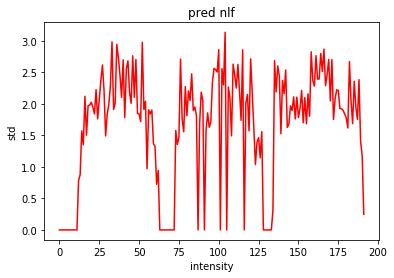

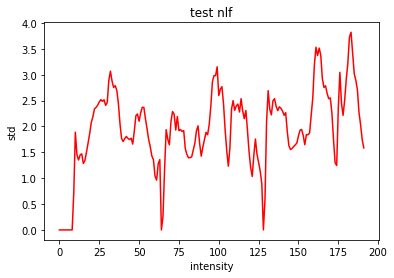

STD OF 6 SAMPLES: 
0.08141890953107135


Iteration 36
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 89s 3ms/step - loss: 1.1324 - val_loss: 0.7342


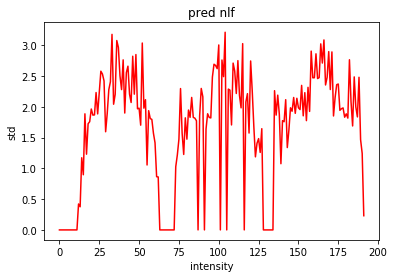

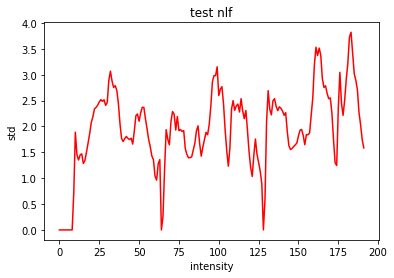

STD OF 6 SAMPLES: 
0.07924568095488473


Iteration 37
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 89s 3ms/step - loss: 1.1232 - val_loss: 0.6460


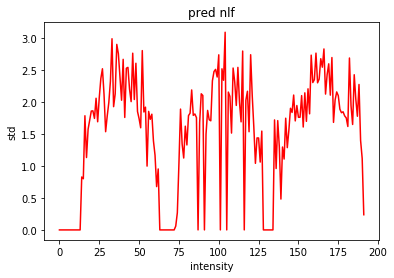

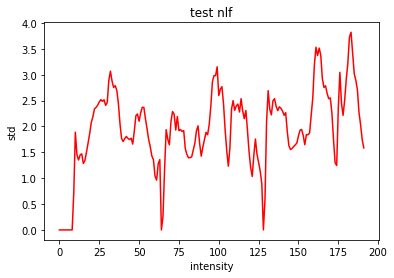

STD OF 6 SAMPLES: 
0.0862465788798077


Iteration 38
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 90s 3ms/step - loss: 1.1082 - val_loss: 0.6364


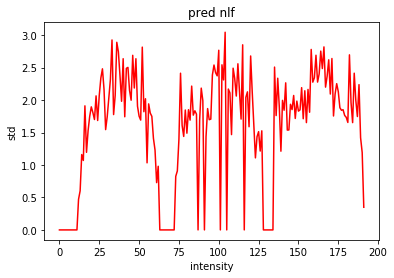

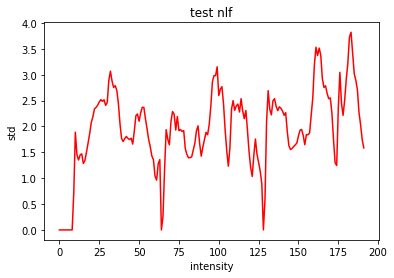

STD OF 6 SAMPLES: 
0.07933078133520276


Iteration 39
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 89s 3ms/step - loss: 1.1178 - val_loss: 0.7411


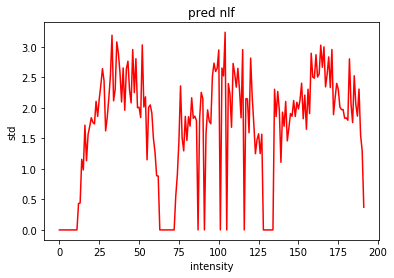

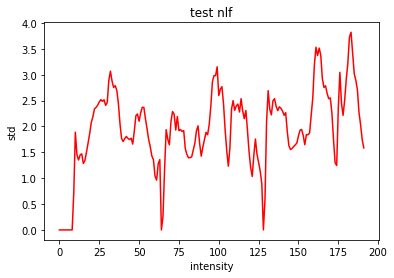

STD OF 6 SAMPLES: 
0.07849884337358513


Iteration 40
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 90s 3ms/step - loss: 1.1000 - val_loss: 0.6958


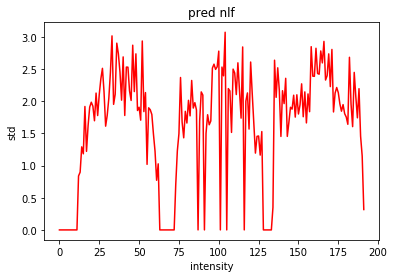

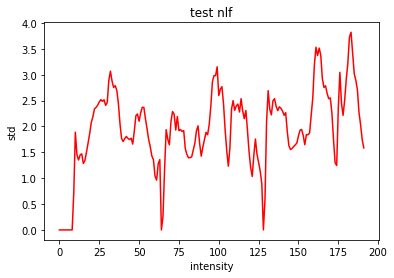

STD OF 6 SAMPLES: 
0.05427587621005964


Iteration 41
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 89s 3ms/step - loss: 1.0895 - val_loss: 0.5719


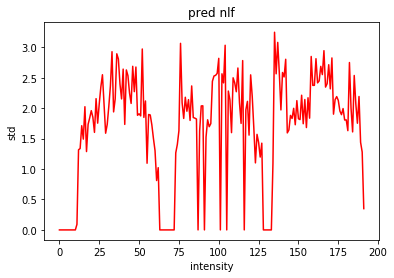

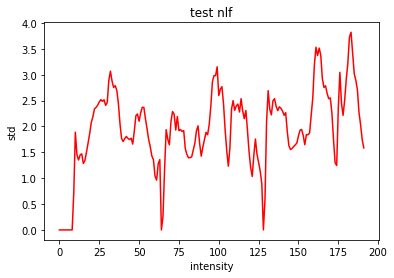

STD OF 6 SAMPLES: 
0.0528008153163847


Iteration 42
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 90s 3ms/step - loss: 1.0868 - val_loss: 0.5963


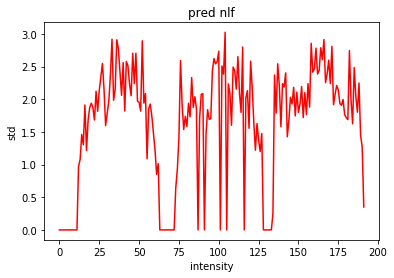

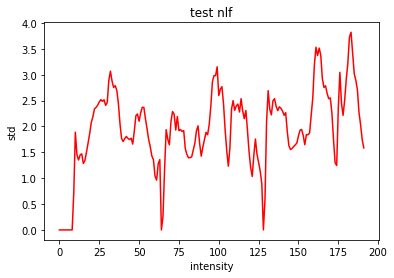

STD OF 6 SAMPLES: 
0.04702453662338566


Iteration 43
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 89s 3ms/step - loss: 1.0836 - val_loss: 0.5698


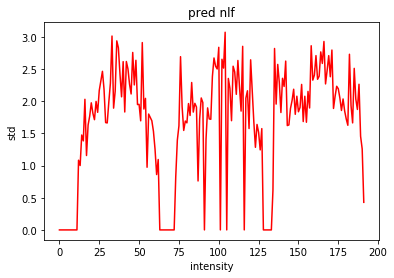

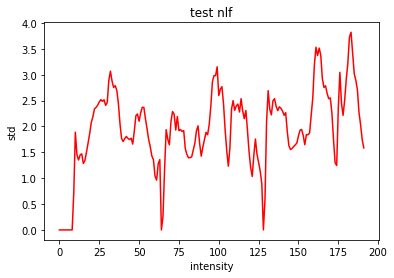

STD OF 6 SAMPLES: 
0.05590621289402368


Iteration 44
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 91s 3ms/step - loss: 1.0752 - val_loss: 0.6585


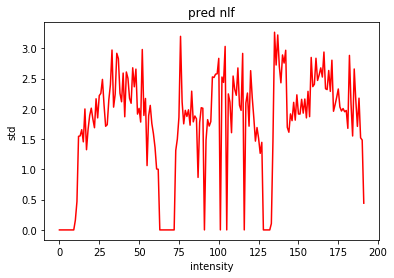

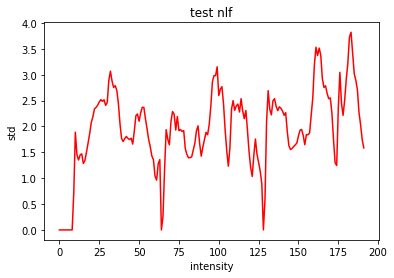

STD OF 6 SAMPLES: 
0.059577315113672


Iteration 45
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 93s 3ms/step - loss: 1.0708 - val_loss: 0.5822


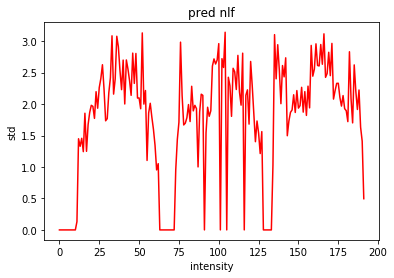

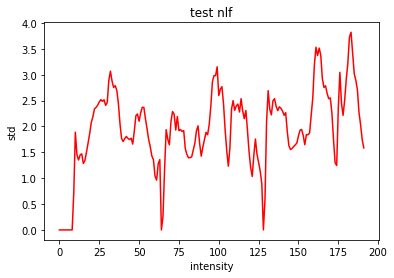

STD OF 6 SAMPLES: 
0.043168809597057246


Iteration 46
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 93s 3ms/step - loss: 1.0566 - val_loss: 0.6980


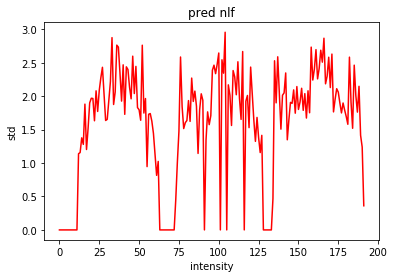

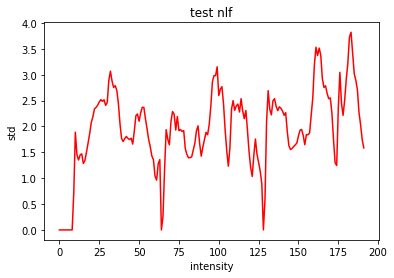

STD OF 6 SAMPLES: 
0.0436514885991362


Iteration 47
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 94s 3ms/step - loss: 1.0531 - val_loss: 0.5848


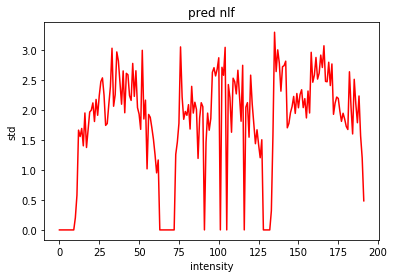

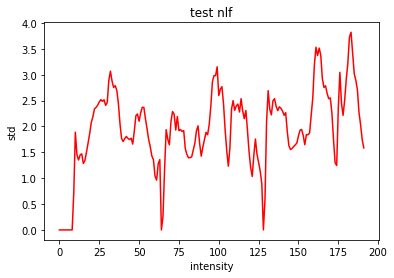

STD OF 6 SAMPLES: 
0.04221727458864899


Iteration 48
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 94s 3ms/step - loss: 1.0505 - val_loss: 0.5820


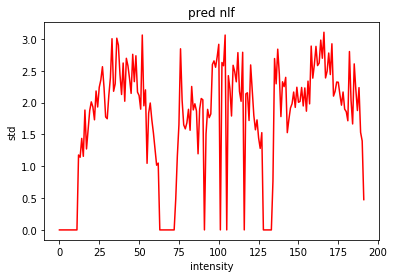

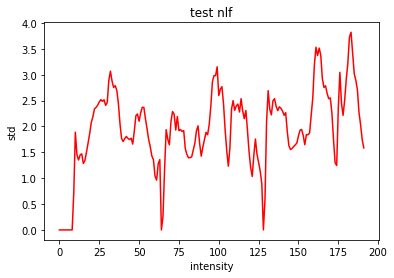

STD OF 6 SAMPLES: 
0.04381320692384194


Iteration 49
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 94s 3ms/step - loss: 1.0399 - val_loss: 0.6899


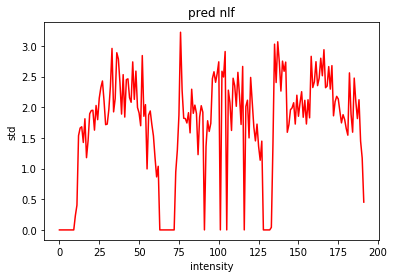

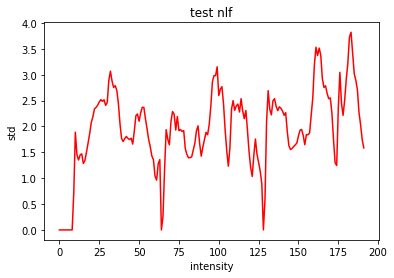

STD OF 6 SAMPLES: 
0.04957377957218467


Iteration 50
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 94s 3ms/step - loss: 1.0392 - val_loss: 0.6135


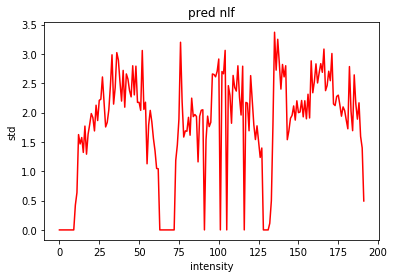

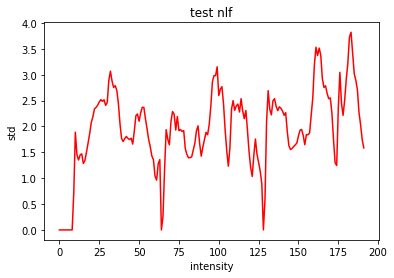

STD OF 6 SAMPLES: 
0.045921529990982445


Iteration 51
Train on 28080 samples, validate on 6480 samples
Epoch 1/1
28080/28080 [==============================] - 94s 3ms/step - loss: 1.0383 - val_loss: 0.6087


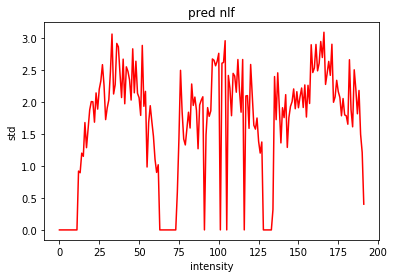

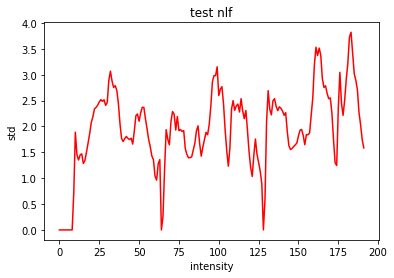

STD OF 6 SAMPLES: 
0.04296919202281287


In [19]:
# Train model ABC

sgd_abc = optimizers.SGD(lr=0.0001, decay=0.00001, momentum=0.9, nesterov=True)
model_abc.compile(optimizer= sgd_abc, loss='mse')
#model_abc.compile(optimizer= sgd_abc, loss=losses.kullback_leibler_divergence)
model_abc, hist_loss_abc, hist_val_loss_abc = train_indep_model(model_abc, [X_,X_,X_], y_, 
                                                                [Xtest_,Xtest_,Xtest_], ytest_, 0.001, abc = True)

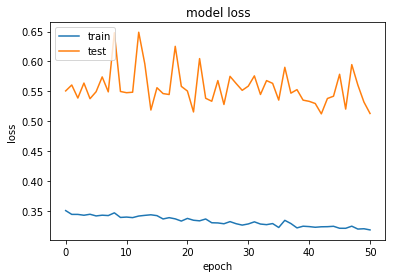

In [29]:
# summarize history for loss
plt.plot(hist_loss_abc)
plt.plot(hist_val_loss_abc)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
# serialize model to JSON
prefix = '3005'
model_abc.summary()
'''model_json = model_abc.to_json()
with open(f"models/model_abc_{prefix}.json", "w") as json_file:
    json_file.write(model_json)'''
# serialize weights to HDF5
model_abc.save_weights(f"models/model_abc_{prefix}.h5")
print("Saved model to disk")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 26, 26, 64)   116672      input_2[0][0]                    
__________________________________________________________________________________________________
model_5 (M

In [31]:
pickle.dump( hist_loss_abc, open( f"models/hist_loss_abc_{prefix}.pickle", "wb" ) )
pickle.dump( hist_val_loss_abc, open( f"models/hist_val_loss_abc_{prefix}.pickle", "wb" ) )

In [ ]:
import matplotlib.pyplot as plt
ii = 27

y_pred = np.transpose(model_abc.predict([[X_[ii]],[X_[ii]],[X_[ii]]]))

fig, ax = plt.subplots()
#y_pred[y_pred < 0] = 0
ax.plot(y_pred,'r')

ax.set(xlabel='intensity', ylabel='std',
       title='pred nlf')
plt.show()

fig, ax = plt.subplots()
ax.plot(y_[ii],'r')

ax.set(xlabel='intensity', ylabel='std',
       title='test nlf')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from keras.utils import plot_model

plot_model(model_abc, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

In [ ]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
import scipy.io


scene = 'Scene_21'
nlf_path = '../Dataset_Final/NLFs/NLF_' + scene + '.mat'
mat = scipy.io.loadmat('../Dataset_Final/NLFs/NLF_' + scene + '.mat')
NLF = mat["NLF"][0]
NLF_r = np.nan_to_num(NLF[0:256])

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y,b,a

order = 5
fs = 30    # sample rate, Hz
cutoff = 2
y,b,a = butter_lowpass_filter(NLF_r, cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)

plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

fig, ax = plt.subplots()
ax.plot(y,'r')

ax.set(xlabel='intensity', ylabel='std',
       title='test nlf filtered')
plt.show()

fig, ax = plt.subplots()
ax.plot(NLF_r,'r')

ax.set(xlabel='intensity', ylabel='std',
       title='test nlf')
plt.show()